In [1]:
# Previous Modeling

import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

# -----------------------
# 1) Load + scope
# -----------------------
df = pd.read_csv("retail_store_inventory.csv")

df = df[(df["Region"] == "North") & (df["Category"] == "Groceries")].copy()
df["Date"] = pd.to_datetime(df["Date"])

# Product별 시간 순 정렬 (Lag 필수)
df = df.sort_values(["Product ID", "Date"]).reset_index(drop=True)

# -----------------------
# 2) Lag features (임시)
# -----------------------
df["lag_1"] = df.groupby("Product ID")["Units Sold"].shift(1)
df["rolling_7_mean"] = (
    df.groupby("Product ID")["Units Sold"]
      .shift(1)
      .rolling(7)
      .mean()
      .reset_index(level=0, drop=True)
)

# Lag로 인해 생긴 결측 제거
df = df.dropna(subset=["lag_1", "rolling_7_mean"]).copy()

# -----------------------
# 3) Date features
# -----------------------
df["DayOfWeek"] = df["Date"].dt.day_name()
df["Month"] = df["Date"].dt.month.astype(int)

# -----------------------
# 4) Time-based Train/Test split
# -----------------------
split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx].copy()
test  = df.iloc[split_idx:].copy()

y_train = train["Units Sold"]
y_test  = test["Units Sold"]

# -----------------------
# 5) Features
# -----------------------
numeric_features = [
    "Inventory Level",
    "Price",
    "Discount",
    "Competitor Pricing",
    "lag_1",
    "rolling_7_mean"
]

categorical_features = [
    "Weather Condition",
    "Holiday/Promotion",
    "Seasonality",
    "DayOfWeek",
    "Month"
]

X_train = train[numeric_features + categorical_features]
X_test  = test[numeric_features + categorical_features]

# -----------------------
# 6) Preprocess + Linear Regression
# -----------------------
preprocess = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

model = Pipeline([
    ("preprocess", preprocess),
    ("lr", LinearRegression())
])

# -----------------------
# 7) Train + Predict
# -----------------------
model.fit(X_train, y_train)
pred = model.predict(X_test)

# -----------------------
# 8) Evaluate
# -----------------------
print("Lag-based Linear Regression")
print("RMSE:", rmse(y_test, pred))
print("MAE :", mean_absolute_error(y_test, pred))

Lag-based Linear Regression
RMSE: 87.95495363042231
MAE : 68.44517399418787


In [2]:
import numpy as np
import pandas as pd

# 1) feature names
num_features = numeric_features

ohe = model.named_steps["preprocess"].named_transformers_["cat"]
cat_features = ohe.get_feature_names_out(categorical_features)

all_features = np.concatenate([num_features, cat_features])

# 2) coefficients (auto)
last_step_name = list(model.named_steps.keys())[-1]
estimator = model.named_steps[last_step_name]
coefs = estimator.coef_

# 3) importance table
fi = pd.DataFrame({
    "feature": all_features,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

fi.head(20)

,feature,coef,abs_coef
0,Inventory Level,62.852976,62.852976
28,Month_6,-9.387813,9.387813
21,DayOfWeek_Tuesday,7.480918,7.480918
32,Month_10,-7.109957,7.109957
33,Month_11,6.910427,6.910427
18,DayOfWeek_Saturday,-6.697461,6.697461
22,DayOfWeek_Wednesday,-6.092297,6.092297
16,DayOfWeek_Friday,5.776360,5.776360
34,Month_12,-5.696975,5.696975
27,Month_5,5.585355,5.585355


In [3]:
fi["group"] = fi["feature"].str.replace(r"^(DayOfWeek|Month)_.*", "Time (Day/Month)", regex=True)
fi.loc[fi["feature"].str.contains("Weather Condition"), "group"] = "Weather"
fi.loc[fi["feature"].str.contains("Seasonality"), "group"] = "Seasonality"
fi.loc[fi["feature"].str.contains("Holiday/Promotion"), "group"] = "Holiday/Promotion"
fi.loc[fi["feature"].isin(["Inventory Level","Price","Discount","Competitor Pricing"]), "group"] = "Pricing/Inventory"
fi.loc[fi["feature"].str.contains("lag_1|rolling_7_mean"), "group"] = "Lag features"

fi.head(20)

,feature,coef,abs_coef,group
0,Inventory Level,62.852976,62.852976,Pricing/Inventory
28,Month_6,-9.387813,9.387813,Time (Day/Month)
21,DayOfWeek_Tuesday,7.480918,7.480918,Time (Day/Month)
32,Month_10,-7.109957,7.109957,Time (Day/Month)
33,Month_11,6.910427,6.910427,Time (Day/Month)
18,DayOfWeek_Saturday,-6.697461,6.697461,Time (Day/Month)
22,DayOfWeek_Wednesday,-6.092297,6.092297,Time (Day/Month)
16,DayOfWeek_Friday,5.776360,5.776360,Time (Day/Month)
34,Month_12,-5.696975,5.696975,Time (Day/Month)
27,Month_5,5.585355,5.585355,Time (Day/Month)


In [4]:
from sklearn.inspection import permutation_importance
import pandas as pd

# 원래 입력 컬럼 이름 (one-hot 전)
input_features = X_test.columns

r = permutation_importance(
    model, X_test, y_test,
    n_repeats=10, random_state=42,
    scoring="neg_mean_absolute_error"
)

perm = pd.DataFrame({
    "feature": input_features,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False)

perm.head(20)

,feature,importance_mean,importance_std
0,Inventory Level,31.289501,2.311630
1,Price,0.205678,0.110123
3,Competitor Pricing,0.117117,0.132491
9,DayOfWeek,0.076622,0.148803
8,Seasonality,0.057469,0.049872
2,Discount,0.010666,0.006449
6,Weather Condition,0.007308,0.056678
7,Holiday/Promotion,-0.007710,0.006002
5,rolling_7_mean,-0.014435,0.026557
10,Month,-0.094651,0.174257


In [5]:
fi_table = perm[['feature', 'importance_mean']]
fi_table.to_csv("feature_importance.csv", index=False)

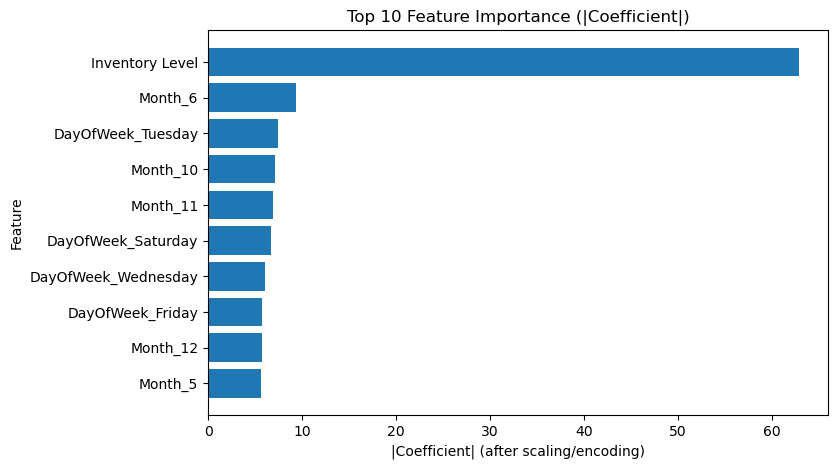

In [7]:
import matplotlib.pyplot as plt

# fi는 너가 만든 DataFrame (columns: feature, coef, abs_coef) 이어야 함
top = fi.sort_values("abs_coef", ascending=False).head(10).iloc[::-1]  # 보기 좋게 역순

plt.figure(figsize=(8,5))
plt.barh(top["feature"], top["abs_coef"])
plt.title("Top 10 Feature Importance (|Coefficient|)")
plt.xlabel("|Coefficient| (after scaling/encoding)")
plt.ylabel("Feature")
plt.show()